In [1]:
import os
from pathlib import Path

from jmetal.core.algorithm import Algorithm
from jmetal.core.quality_indicator import *
from jmetal.util.solution import print_function_values_to_file, print_variables_to_file, read_solutions

In [4]:
def generate_summary_from_experiment(input_dir, quality_indicators, problems, evaluations,
                                     reference_fronts = ''):
    reference_change = 2500
    ref_time = 1
    if not quality_indicators:
        quality_indicators = []
        
    with open('QualityIndicatorSummary.csv', 'w+') as of:
        of.write('Algorithm,Problem,ExecutionId,Evaluations,IndicatorName,IndicatorValue\n')

    for dirname, _, filenames in os.walk(input_dir):
        print(dirname)
        for filename in sorted(filenames):
            try:
                # Linux filesystem
                algorithm, problem = dirname.split('/')[-2:]
            except ValueError:
                # Windows filesystem
                algorithm, problem = dirname.split('\\')[-2:]

            for problem_name in problems:
                if 'FUN' in filename and problem == problem_name:
                    solutions = read_solutions(os.path.join(dirname, filename))
                    digits = [s for s in filename.split('.') if s.isdigit()]
                    run_tag = digits[0]
                    evaluation_tag = evaluations
                    if len(digits) > 1:
                        evaluation_tag = digits[1]

                    for indicator in quality_indicators:
                        ref_time = min(int(int(evaluation_tag)/reference_change) + 1, 20)
                        reference_front_file = "resources/reference_front/{}_time{}.pf".format(problem_name, ref_time) 
  
                        # Add reference front if any
                        if hasattr(indicator, 'reference_front'):
                            if Path(reference_front_file).is_file():
                                reference_front = []
                                with open(reference_front_file) as file:
                                    for line in file:
                                        reference_front.append([float(x) for x in line.split()])

                                indicator.reference_front = reference_front
                            elif Path("resources/reference_front/{}.pf".format(problem_name)).is_file():
                                reference_front = []
                                with open("resources/reference_front/{}.pf".format(problem_name)) as file:
                                    for line in file:
                                        reference_front.append([float(x) for x in line.split()])

                                indicator.reference_front = reference_front
                            else:
                                print("no reference front for {}".format(problem))

                        result = indicator.compute([solutions[i].objectives for i in range(len(solutions))])

                        # Save quality indicator value to file
                        with open('QualityIndicatorSummary.csv', 'a+') as of:
                            of.write(','.join([algorithm, problem, str(run_tag), str(evaluation_tag), indicator.get_short_name(), str(result)]))
                            of.write('\n')

In [5]:
output_directory = "data-500pop-100000evals-20runs-"

generate_summary_from_experiment(output_directory, [InvertedGenerationalDistance(None)], 
                                 [ 
                                     "UDF1", "UDF2", "UDF3", "UDF4", "UDF5", "UDF6", "UDF8",
                                     "CDF1", "CDF2", "CDF3", "CDF4", "CDF5", "CDF6", "CDF7", "CDF8",
                                     "CDF9", "CDF10", "CDF11", "CDF12", "CDF13", "CDF14", "CDF15",
                                     "JY1", "JY2", "JY3", "JY5", "JY6", "JY7", "JY8"
                                 ], 100000)

data-500pop-100000evals-20runs-
data-500pop-100000evals-20runs-/MOEAD-e
data-500pop-100000evals-20runs-/MOEAD-e/UDF3
data-500pop-100000evals-20runs-/MOEAD-e/UDF6
data-500pop-100000evals-20runs-/MOEAD-e/JY2
data-500pop-100000evals-20runs-/MOEAD-e/CDF7
data-500pop-100000evals-20runs-/MOEAD-e/JY3
data-500pop-100000evals-20runs-/MOEAD-e/CDF14
data-500pop-100000evals-20runs-/MOEAD-e/UDF1
data-500pop-100000evals-20runs-/MOEAD-e/CDF2
data-500pop-100000evals-20runs-/MOEAD-e/CDF13
data-500pop-100000evals-20runs-/MOEAD-e/UDF4
data-500pop-100000evals-20runs-/MOEAD-e/UDF2
data-500pop-100000evals-20runs-/MOEAD-e/JY5
data-500pop-100000evals-20runs-/MOEAD-e/CDF1
data-500pop-100000evals-20runs-/MOEAD-e/CDF3
data-500pop-100000evals-20runs-/MOEAD-e/CDF8
data-500pop-100000evals-20runs-/MOEAD-e/CDF6
data-500pop-100000evals-20runs-/MOEAD-e/CDF15
data-500pop-100000evals-20runs-/MOEAD-e/CDF9
data-500pop-100000evals-20runs-/MOEAD-e/CDF4
data-500pop-100000evals-20runs-/MOEAD-e/JY6
data-500pop-100000evals-20run

In [94]:
import pandas as pd

In [191]:
def plot_pf(problem):
    pf = pd.read_csv("resources/reference_front/{}_time1.pf".format(problem), delimiter = "\t")
    pf2 = pd.read_csv("resources/reference_front/{}_time4.pf".format(problem), delimiter = "\t")
    pf3 = pd.read_csv("resources/reference_front/{}_time8.pf".format(problem), delimiter = "\t")
    
    ax1 = pf.plot.scatter(x=0, y=1)
    ax2 = pf2.plot.scatter(x=0, y=1, ax=ax1)
    ax3 = pf3.plot.scatter(x=0, y=1, ax=ax1)

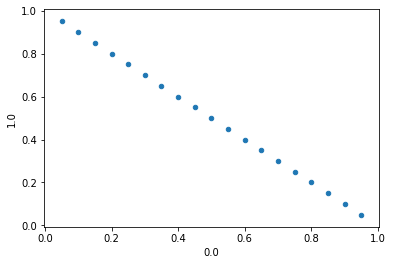

In [186]:
pf = pd.read_csv("resources/reference_front/CDF3_time2.pf", delimiter = "\t")
ax = pf.plot.scatter(x=0, y=1)

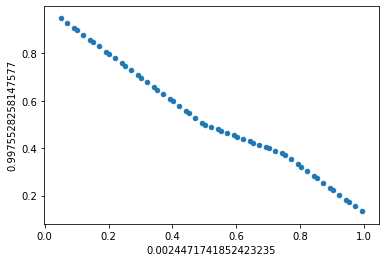

In [193]:
plot_pf("CDF11")

In [25]:
import pandas as pd
import numpy as np

In [33]:
df = pd.read_csv("QualityIndicatorSummary.csv")

In [26]:
igd = df[(df["Problem"] == "UDF3") & (df["Evaluations"] == 1000) & (df["Algorithm"] == "MOEAD")]["IndicatorValue"]

In [28]:
np.std(igd)

3.128348284353192

In [36]:
np.average(igd)

10.314740093914242

In [58]:
problems_cdf = ["CDF1", "CDF2", "CDF3", "CDF4", "CDF5", "CDF6", "CDF7", "CDF8",
            "CDF9", "CDF10", "CDF11", "CDF12", "CDF13", "CDF14", "CDF15"]
problems_udf = ["UDF1", "UDF2", "UDF3", "UDF4", "UDF5", "UDF6", "UDF8"]
problems_jy = ["JY1", "JY2", "JY3", "JY5", "JY6", "JY7", "JY8"]

In [79]:
def write_igd_csv(filename, problems):
    with open('igd.csv', 'w+') as of:
            of.write('Algorithm,Problem,Evaluations,IGD-avg,IDG-std\n')

    for algorithm in ["MOEAD", "MOEAD-e"]:
        for problem in problems:
            for evals in range(1000, 100000, 1000):
                igd_df = df[(df["Problem"] == problem) 
                            & (df["Evaluations"] == evals) 
                            & (df["Algorithm"] == algorithm)]["IndicatorValue"]

                with open("igd.csv", "a+") as f:
                    f.write(",".join([algorithm, problem, str(evals), str(np.average(igd_df)), str(np.std(igd_df))]))
                    f.write("\n")

In [76]:
def write_raw_csv(filename, problems):
    with open(filename, "w+") as f:
        for algorithm in ["MOEAD", "MOEAD-e"]:
            for evals in range(1000, 101000, 1000):
                f.write(",".join([algorithm, str(evals)]))
                for problem in problems:
                    igd_df = df[(df["Problem"] == problem)
                                & (df["Algorithm"] == algorithm)
                                & (df["Evaluations"] == evals)]            

                    f.write(",{}".format(problem))
                    for i, row in igd_df.iterrows():
                        f.write(",{}".format(row["IndicatorValue"]))

                f.write("\n")

In [78]:
write_raw_csv("jy-raw.csv", problems_jy)